In [81]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [82]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D
import matplotlib.pyplot as plt
import pandas as pd

In [83]:
Image_Size=256
Batch_Size=32
Channels = 3
Epochs = 10

In [84]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("Dataset",
                                                             shuffle=True,
                                                             image_size = (Image_Size,Image_Size),
                                                             batch_size = Batch_Size)

Found 300 files belonging to 3 classes.


In [85]:
class_names = dataset.class_names
class_names

['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___healthy']

In [86]:
len(dataset)

10

In [87]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 256, 256, 3)
[1 2 0 1 1 0 1 2 0 0 1 1 2 1 1 2 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0]


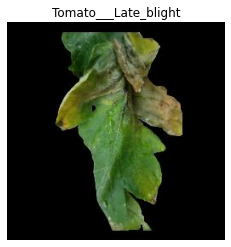

In [88]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")
    print(image_batch.shape)
    print(label_batch.numpy())

In [89]:
len(dataset)

10

In [90]:
print(image_batch[0].shape)

(256, 256, 3)


In [91]:
train_size = 0.8
len(dataset)*train_size

8.0

In [92]:
train_ds = dataset.take(8)
len(train_ds)

8

In [93]:
test_ds = dataset.skip(8)
len(test_ds)

2

In [94]:
test_size = 0.1
len(dataset)*test_size

1.0

In [95]:
val_size = 0.1
len(dataset)*val_size

1.0

In [96]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1, shuffle=True, shuffle_size=300):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split *ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [97]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [98]:
len(train_ds)

8

In [99]:
len(val_ds)

1

In [100]:
len(test_ds)

1

In [101]:
train_ds = train_ds.cache().shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)

In [102]:
val_ds = val_ds.cache().shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)

In [103]:
test_ds = test_ds.cache().shuffle(200).prefetch(buffer_size=tf.data.AUTOTUNE)

In [104]:
resize_and_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [105]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2)])

In [106]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
     # 32 features / layers / features, (3,3) is filter size
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input_shape),  
   
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),   
    
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),    
    
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),   
    
    layers.Flatten(),
    
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [107]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [108]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [109]:
history = model.fit(
    train_ds,
    epochs=Epochs,
    batch_size = Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
8/8 [==============================] - 22s 2s/step - loss: 1.1039 - accuracy: 0.3203 - val_loss: 1.0856 - val_accuracy: 0.4062
Epoch 2/10
8/8 [==============================] - 18s 2s/step - loss: 1.0958 - accuracy: 0.3516 - val_loss: 1.1442 - val_accuracy: 0.2188
Epoch 3/10
8/8 [==============================] - 19s 2s/step - loss: 1.0926 - accuracy: 0.3633 - val_loss: 1.0781 - val_accuracy: 0.4688
Epoch 4/10
8/8 [==============================] - 18s 2s/step - loss: 1.0715 - accuracy: 0.5039 - val_loss: 1.0464 - val_accuracy: 0.5312
Epoch 5/10
8/8 [==============================] - 18s 2s/step - loss: 1.0384 - accuracy: 0.4805 - val_loss: 0.9830 - val_accuracy: 0.5000
Epoch 6/10
8/8 [==============================] - 18s 2s/step - loss: 0.8753 - accuracy: 0.6250 - val_loss: 0.6612 - val_accuracy: 0.7188
Epoch 7/10
8/8 [==============================] - 18s 2s/step - loss: 0.7020 - accuracy: 0.6914 - val_loss: 0.5494 - val_accuracy: 0.7500
Epoch 8/10
8/8 [==================

In [110]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 900ms/step - loss: 0.6247 - accuracy: 0.6875


In [32]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [111]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 8}

In [112]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

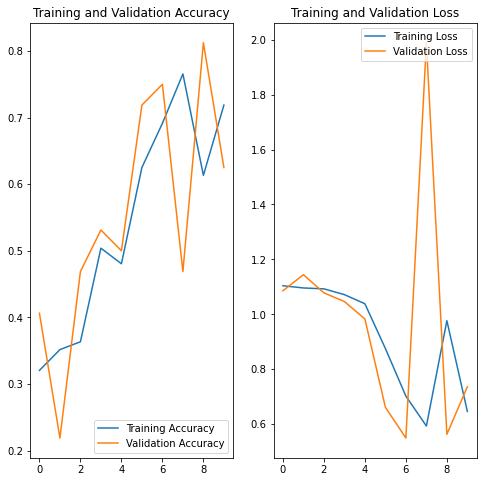

In [114]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(Epochs), acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1,2,2)
plt.plot(range(Epochs), loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [151]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [152]:
 pred=model.predict(test_ds)

1/1 [==============================] - 1s 577ms/step


In [153]:
pred=pred.argmax(axis=-1)

In [154]:
print(pred)

[1 2 1 1 2 1 0 1 1 2 2 2 2 1 1 1 2 1 2 0 2 1 0 2 2 2 1 1 0 2 2 1]


In [155]:
for i,j in test_ds:
    count=j.numpy()

In [156]:
print(count)

[1 2 0 0 0 1 1 1 1 1 2 2 2 1 0 1 2 1 2 1 2 1 1 2 2 2 0 0 0 2 2 1]


In [157]:
print(classification_report(pred,count))

              precision    recall  f1-score   support

           0       0.14      0.25      0.18         4
           1       0.69      0.64      0.67        14
           2       1.00      0.86      0.92        14

    accuracy                           0.69        32
   macro avg       0.61      0.58      0.59        32
weighted avg       0.76      0.69      0.72        32



In [158]:
print(count)

[1 2 0 0 0 1 1 1 1 1 2 2 2 1 0 1 2 1 2 1 2 1 1 2 2 2 0 0 0 2 2 1]


first image to predict
actual label: Tomato___Late_blight
1/1 [==============================] - 1s 505ms/step
predictions: Tomato___Late_blight


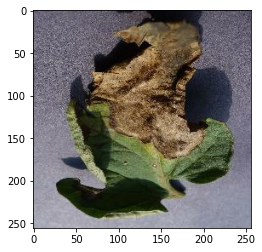

In [160]:
for images_batch, labels_batch in test_ds.take(1):
    # working on a first image in a batch of 32 (BATCH_SIZE)
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_predictions = model.predict(images_batch)  # predict all images
    print("predictions:", class_names[np.argmax(batch_predictions[0])]) # first image